# Baseline: Logistic Regression + TF-IDF

In this notebook I'm going to create a strong baseline model using classic ML algorithms. 

In [1]:
# !pip install skl2onnx==1.12.0 onnxruntime==1.13.1 protobuf==3.20.1 optuna==3.0.4
# !pip install --no-cache-dir git+https://github.com/optuna/optuna

In [19]:
# !pip install pgzip==0.3.5

## Imports

In [20]:
# import nltk
# nltk.download("stopwords")

In [21]:
import os
import gc
import pickle
import pgzip
from pathlib import Path
import numpy as np
from collections import Counter
from pprint import pprint

In [3]:
import shap
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import optuna
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Parameters

In [5]:
SEED = 42

In [6]:
F1_AVERAGING = "macro"

VERSION = "0.4.0"

## Paths

### Input

In [7]:
RELATIVE_PATH = os.path.join("../", "data")

### Output

In [40]:
SAVED_MODELS_PATH = "../models"
Path(SAVED_MODELS_PATH).mkdir(parents=True, exist_ok=True)

In [41]:
VECTORIZER_PATH_PICKLE = os.path.join(
    SAVED_MODELS_PATH, f"tfidf_vectorizer_{VERSION}.pkl"
)

In [42]:
LOGREG_PATH_PICKLE = os.path.join(
    SAVED_MODELS_PATH, f"logreg_classifier_{VERSION}.pkl"
)

## Loading data

In [11]:
class_col = "label"
text_col = "text"

In [12]:
reviews = pd.read_parquet(os.path.join(RELATIVE_PATH, "split_reviews.parquet")).query(
    "label != 'neutral'"
)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175551 entries, 1 to 206536
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   label   175551 non-null  category
 1   text    175551 non-null  object  
 2   fold    175551 non-null  object  
dtypes: category(1), object(2)
memory usage: 4.2+ MB


In [13]:
train = reviews[reviews["fold"] == "train"]
test = reviews[reviews["fold"] == "test"]
dev = reviews[reviews["fold"] == "dev"]

del reviews
gc.collect()

0

In [14]:
X_train, X_test, X_dev, y_train, y_test, y_dev = (
    train[text_col].values.tolist(),
    test[text_col].values.tolist(),
    dev[text_col].values.tolist(),
    train[class_col].values.tolist(),
    test[class_col].values.tolist(),
    dev[class_col].values.tolist(),
)

del train, test, dev
gc.collect()

len(X_train), len(X_test), len(X_dev), len(y_train), len(y_test), len(y_dev)

(149218, 13166, 13167, 149218, 13166, 13167)

## Evaluation metrics

In [15]:
target_counts = Counter(y_test + y_dev)

total = sum(target_counts.values(), 0.0)
for key in target_counts:
    target_counts[key] /= total

print(target_counts)

Counter({'positive': 0.847415790073292, 'negative': 0.15258420992670793})


Taking into account the distribution of the target, I will select the F1-score with macro-averaging, and we will use the F1-score with micro-averaging to illustrate the difference.

## Investigation

For baseline model, I've decided to start with TF-IDF and Logistic Regression.

### Text Encoding

#### Hyperparameter Investigation

Instead of using `TfidfVectorizer` to check different hyperparameters it will be faster to use `CountVectorizer`, because it has almost the same hyperparameters.

##### `lowercase`

In [15]:
vectorizer = CountVectorizer(lowercase=False)
vectors_wo_lowercase = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors_wo_lowercase.shape} with lowercase turned off"
)

The size of the train dataset is (175556, 767258) with lowercase turned off


In [16]:
vectorizer = CountVectorizer()
vectors_w_lowercase = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors_w_lowercase.shape} with lowercase turned on"
)

The size of the train dataset is (175556, 653993) with lowercase turned on


In [17]:
vectors_wo_lowercase.shape[1] - vectors_w_lowercase.shape[1]

113265

The difference in vocabulary size between cased and uncased models is more than 100 000, so we better stick to lowercase 

##### `max_df` and `min_df`

`min_df` is used for removing terms that appear **too infrequently**. For example:

 - `min_df = 0.01` means "ignore terms that appear in **less than 1% of the documents**".
 - `min_df = 5` means "ignore terms that appear in **less than 5 documents**".  
 
The default `min_df` is `1`, which means "ignore terms that appear in **less than 1 document**".  
Thus, the default setting does not ignore any terms.

`max_df` is used for removing terms that appear **too frequently**, also known as "corpus-specific stop words". For example:

 - `max_df = 0.5` means "ignore terms that appear in **more than 50% of the documents**".
 - `max_df = 25` means "ignore terms that appear in **more than 25 documents**".  
 
The default `max_df` is `1.0`, which means "ignore terms that appear in **more than 100% of the documents**".  
Thus, the default setting does not ignore any terms.

In [18]:
vectorizer.get_feature_names_out()[:50]

array(['00', '000', '0000', '00000', '000000',
       '000000000000000000попкорн000000000000', '000000000000001',
       '000000000000на', '00000000000во', '00000000000данной',
       '00000000000есть000000000000000',
       '00000000000есть000000000000000000', '0000000000жевать',
       '0000000000ненавижу00000000', '00000000016', '000000000надо',
       '000000000разговаривать0000000000', '00000000визуальная',
       '00000001', '00000громко', '00000точек', '00001', '00007', '0001',
       '0002', '000доктора', '000какой', '000косметические', '000р',
       '000теряются', '001', '002', '003', '00381', '006', '007', '00в',
       '00вых', '00м', '00по', '00с', '00х', '00ые', '00ых', '01', '011',
       '013', '014', '01минуту', '01ч37мин'], dtype=object)

We can see that if we do not limit the vocabulary, we will have very infrequent words in the corpora, so we better do it.  
For that we have to choose the `min_df` and `max_df` thresholds.

In [19]:
vectorizer = CountVectorizer(min_df=0.8)
vectors = vectorizer.fit_transform(X_train)
vectors.shape

(175556, 7)

In [20]:
vectorizer.get_feature_names_out()

array(['как', 'на', 'не', 'но', 'то', 'что', 'это'], dtype=object)

These words are in 80% of all reviews, and this is understandable, since these are particles, prepositions and conjunctions.

In [21]:
MIN_DF = 0.01
vectorizer = CountVectorizer(min_df=MIN_DF)
vectors = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors.shape} with lowercase turned on and min_df={MIN_DF}"
)

The size of the train dataset is (175556, 3286) with lowercase turned on and min_df=0.01


In [22]:
vectorizer.get_feature_names_out()[:50]

array(['10', '100', '11', '12', '13', '15', '16', '18', '20', '2012',
       '21', '30', '3d', '40', '50', '60', '70', '80', '90', 'dc',
       'marvel', 'of', 'the', 'абсолютно', 'аватар', 'автор', 'автора',
       'авторов', 'авторы', 'аж', 'актер', 'актера', 'актерам',
       'актерами', 'актерах', 'актеров', 'актером', 'актерская',
       'актерский', 'актерского', 'актерской', 'актерскую', 'актеры',
       'актриса', 'актрисы', 'актёр', 'актёра', 'актёров', 'актёрская',
       'актёрский'], dtype=object)

Now it's much better. We removed unpopular tokens and reduced the vocabulary from ~670K to 3.3K tokens.

In [23]:
MIN_DF = 0.01
MAX_DF = 0.9

vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF)
vectors = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors.shape} with lowercase turned on and min_df={MIN_DF} and max_df={MAX_DF}"
)

The size of the train dataset is (175556, 3283) with lowercase turned on and min_df=0.01 and max_df=0.9


I'll leave default value of `max_df` - 1.

##### `ngram_range`

The lower and upper boundary of the range of n-values for different n-grams to be extracted.  
All values of n such that min_n ≤ n ≤ max_n will be used.   

For example a `ngram_range` of `(1, 1)` means only `unigrams`, `(1, 2)` means `unigrams` and `bigrams`, and `(2, 2)` means only `bigrams`.

In [24]:
NGRAM_RANGE = (1, 2)
MIN_DF = 0.01

vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, min_df=MIN_DF)

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
dev_vectors = vectorizer.transform(X_dev)

print(
    f"The size of the train dataset is {train_vectors.shape} with lowercase turned on and min_df={MIN_DF} and ngram_range={NGRAM_RANGE}"
)

The size of the train dataset is (175556, 4624) with lowercase turned on and min_df=0.01 and ngram_range=(1, 2)


In [25]:
vectorizer.get_feature_names_out()[:50]

array(['10', '10 лет', '100', '11', '12', '13', '15', '16', '18', '20',
       '2012', '21', '30', '3d', '40', '50', '60', '70', '80', '90', 'dc',
       'marvel', 'of', 'the', 'абсолютно', 'абсолютно все',
       'абсолютно не', 'аватар', 'автор', 'автора', 'авторов', 'авторы',
       'аж', 'актер', 'актера', 'актерам', 'актерами', 'актерах',
       'актеров', 'актером', 'актерская', 'актерская игра', 'актерский',
       'актерский состав', 'актерского', 'актерской', 'актерской игры',
       'актерскую', 'актерскую игру', 'актеры'], dtype=object)

From my experience, usually `(1, 2)` is a good default value for the `ngram_range`. Sometimes `(1, 3)` can be a little bit better.

### Classification

For the base model, I always use logistic regression as a classifier.

In [26]:
log_reg = LogisticRegression(
    random_state=SEED, class_weight="balanced", solver="saga", max_iter=1_000
)
log_reg.fit(train_vectors, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [27]:
pred_labels = log_reg.predict(dev_vectors)
f1_micro = f1_score(y_dev, pred_labels, average="micro")
f1_macro = f1_score(y_dev, pred_labels, average="macro")

print(f"F1 score with micro-averaging is {f1_micro.round(5)}")
print(f"F1 score with macro-averaging is {f1_macro.round(5)}")

F1 score with micro-averaging is 0.72584
F1 score with macro-averaging is 0.62215


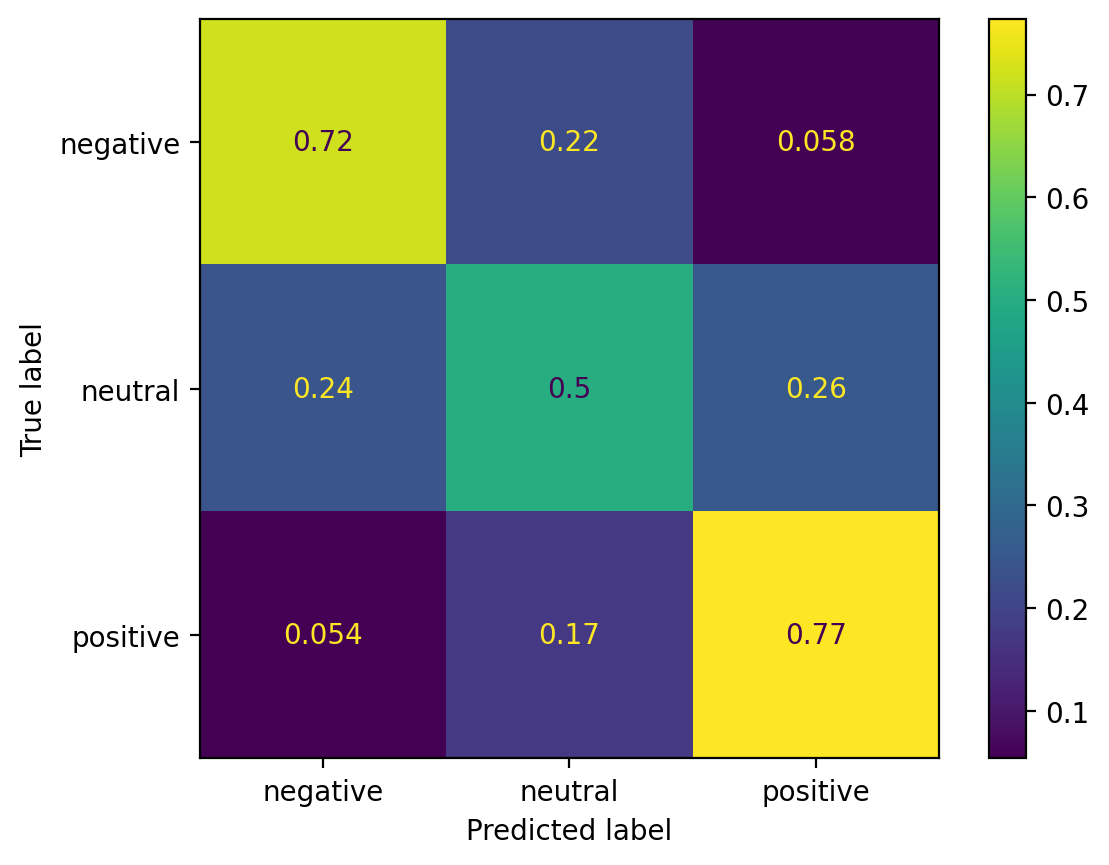

In [28]:
cm = confusion_matrix(y_dev, pred_labels, labels=log_reg.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

disp.plot()

### Hyperparameter Tuning

For Logistic Regression we can tune the regularization strength (`C`), `solver` and `penalty` type.  
In this notebook, I will only tune the first one using Optuna.

For TF-IDF ...

In [ ]:
stopwords_to_remove = [""]

In [45]:
russian_stopwords = stopwords.words("russian")
russian_stopwords[::10]

['и',
 'как',
 'к',
 'было',
 'когда',
 'был',
 'потом',
 'ней',
 'будто',
 'этот',
 'почти',
 'никогда',
 'больше',
 'разве',
 'лучше',
 'между']

In [50]:
print(russian_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [37]:
distributions = {
    "ngram_range": optuna.distributions.CategoricalDistribution(
        choices=((1, 1), (1, 2), (1, 3))
    ),
    "min_df": optuna.distributions.IntDistribution(low=5, high=10),
    "lowercase": optuna.distributions.CategoricalDistribution(choices=(True, False)),
}

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.


For hyperparameter tuning we will use only a fraction of the train data to speed up the process.

In [34]:
X_train_hyper, _, y_train_hyper, _ = train_test_split(
    X_train, y_train, test_size=0.9, random_state=SEED
)

len(X_train_hyper)

17555

In [35]:
study = optuna.create_study(direction="maximize")
n_trials = 20

[I 2024-02-02 10:14:50,240] A new study created in memory with name: no-name-35d394f8-ad23-4cb0-b5a6-ebbc7896d788


In [36]:
for _ in tqdm(range(n_trials)):
    trial = study.ask(distributions)

    vectorizer_params = {
        "min_df": trial.params["min_df"],
        "ngram_range": trial.params["ngram_range"],
        "lowercase": trial.params["lowercase"],
    }

    review_vectorizer = TfidfVectorizer(**vectorizer_params)
    train_vectors = review_vectorizer.fit_transform(X_train_hyper)

    clf = LogisticRegressionCV(
        cv=5,
        solver="saga",
        class_weight="balanced",
        max_iter=1_000,
        random_state=SEED,
    )
    clf.fit(train_vectors, y_train_hyper)

    pred_labels = clf.predict(dev_vectors)
    f1 = f1_score(y_dev, pred_labels, average=F1_AVERAGING)

    study.tell(trial, f1)

  0%|          | 0/20 [06:39<?, ?it/s]


NameError: name 'log_reg' is not defined

In [ ]:
study.best_params, study.best_value

({'C': 6.910877670014768e-06}, 0.6221531301627613)

Let's now make a simple pipeline with two components: `TfidfVectorizer` and `LogisticRegression` to save model in one file.

## Modelling

### Vectorizing reviews with TF-IDF

#### Train

In [22]:
vectorizer_params = {
    # "min_df": 0.01,
    "ngram_range": (1, 3),
    "max_features": 100_000,
}

review_vectorizer = TfidfVectorizer(**vectorizer_params)

In [23]:
review_vectorizer.fit(X_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

#### Save

In [38]:
print(VECTORIZER_PATH_PICKLE)

with pgzip.open(VECTORIZER_PATH_PICKLE, "wb") as f:
    pickle.dump(review_vectorizer, f)

../data/saved_models/tfidf_vectorizer_0.4.0.pkl


#### Load

In [24]:
with pgzip.open(VECTORIZER_PATH_PICKLE, "rb") as f:
    review_vectorizer = pickle.load(f)

#### Transform

In [36]:
train_vectors = review_vectorizer.transform(X_train)

### Classifying reviews with Logistic Regression

#### Train

In [37]:
log_reg = LogisticRegression(
    C=1,
    penalty="l2",
    random_state=SEED,
    solver="saga",
    max_iter=5000,
    class_weight="balanced",
    verbose=0,
)

In [38]:
log_reg.fit(train_vectors, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=5000, random_state=42,
                   solver='saga')

#### Save

In [39]:
print(LOGREG_PATH_PICKLE)

with pgzip.open(LOGREG_PATH_PICKLE, "wb") as f:
    pickle.dump(log_reg, f)

../data/saved_models/logreg_classifier_0.4.0.pkl


#### Load

In [27]:
with pgzip.open(LOGREG_PATH_PICKLE, "rb") as f:
    log_reg = pickle.load(f)

### Evaluation

In [28]:
test_vectors = review_vectorizer.transform(X_test)
# dev_vectors = review_vectorizer.transform(X_dev)

In [29]:
pred_labels = log_reg.predict(test_vectors)
f1 = f1_score(y_test, pred_labels, average="binary", pos_label="positive")

print(f"F1 score with {F1_AVERAGING}-averaging is {f1.round(5)}")

F1 score with macro-averaging is 0.95829


Now we have our pipeline and we can save it.  
We have several choices: ONNX, joblib, pickle.

## Error analysis

### Loading Models

In [51]:
#TODO write function for loading models, which will take as parameters vectorizer name, model name and their versions

with open(VECTORIZER_PATH_PICKLE, "rb") as f:
    review_vectorizer = pickle.load(f)

with open(LOGREG_PATH_PICKLE, "rb") as f:
    log_reg = pickle.load(f)

### Making Predictions

In [30]:
test_vectors = review_vectorizer.transform(X_test)

pred_labels = log_reg.predict(test_vectors)
f1 = f1_score(y_test, pred_labels, average="binary", pos_label="positive")

print(f"F1 score with {F1_AVERAGING}-averaging is {f1.round(5)}")

F1 score with macro-averaging is 0.95829


### Confusion Matrices

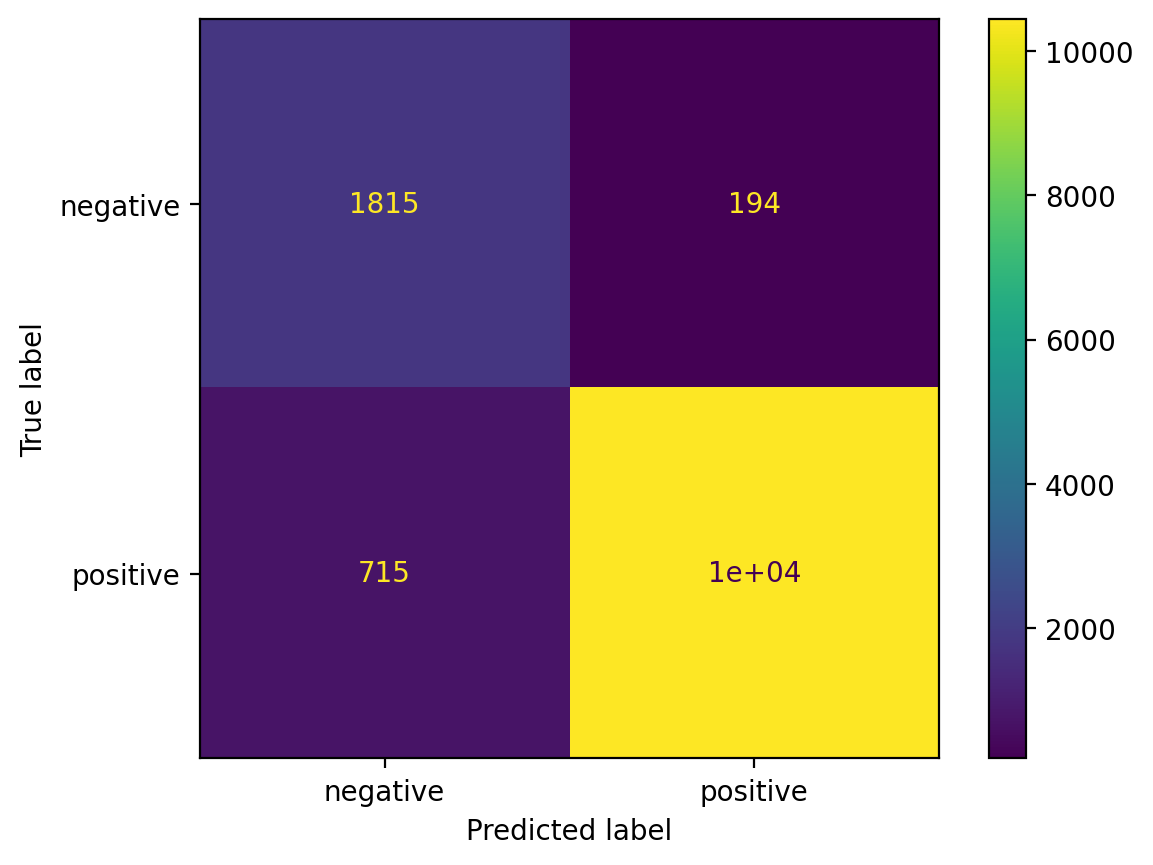

In [53]:
cm = confusion_matrix(y_test, pred_labels, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

disp.plot()

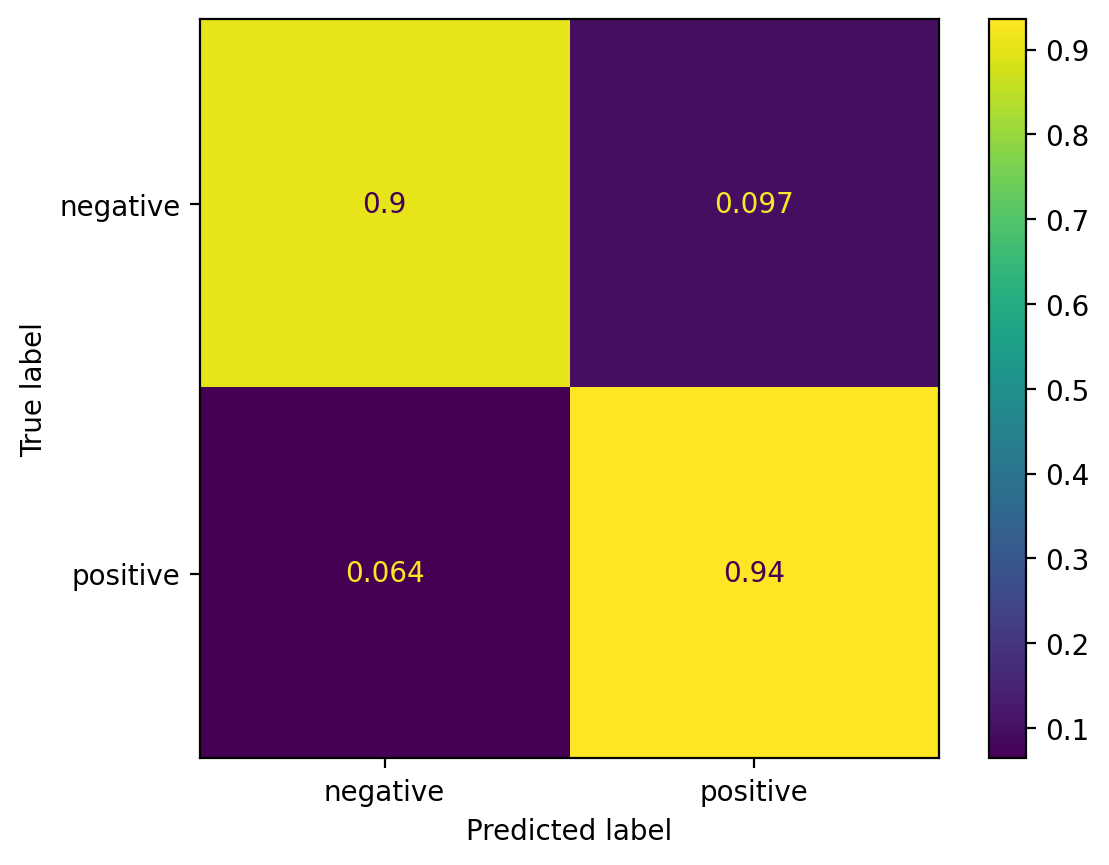

In [54]:
cm = confusion_matrix(y_test, pred_labels, labels=log_reg.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

disp.plot()

- The most problematic class is *neutral*. It can be easily be mistaken for negative (29% objects) and positive (33% objects) classes. 
- 15% of negative labels were predicted as neutral. 
- 9% of positive labels were predicted as neutral. 

### Looking at the errors

Let's look not only at the predicted labels, but also at the probabilities.  

For that we will use `predict_proba` method:

In [56]:
pred_proba = log_reg.predict_proba(test_vectors)

pred_proba

array([[0.25673345, 0.74326655],
       [0.14773576, 0.85226424],
       [0.34704167, 0.65295833],
       ...,
       [0.56330367, 0.43669633],
       [0.05985315, 0.94014685],
       [0.93662427, 0.06337573]])

To determine the order of the classes we will use `classes_` attribute:

In [57]:
log_reg.classes_

array(['negative', 'positive'], dtype='<U8')

Now it's time to merge `pred_proba` and `pipe.classes_` for better readability:

In [58]:
y_pred = [dict(zip(log_reg.classes_, pred)) for pred in pred_proba]
y_pred[0:3]

[{'negative': 0.2567334535996134, 'positive': 0.7432665464003866},
 {'negative': 0.14773576110511077, 'positive': 0.8522642388948892},
 {'negative': 0.34704166684824655, 'positive': 0.6529583331517534}]

Let's determine the indices of our errors:

In [60]:
error_indices = np.where((y_test != pred_labels).astype(int) == 1)[0]
error_indices[:10]

array([ 13,  28,  59,  62,  70,  88, 102, 103, 110, 140])

Looking at the errors:

In [61]:
for error_index in error_indices[:3]:
    print(f"Actual label: {y_test[error_index]}")
    print(f"Predicted label: {pred_labels[error_index]}")
    print(f"Probabilities :{y_pred[error_index]}\n")

    pprint(X_test[error_index], width=160)
    print("\n")

Actual label: positive
Predicted label: negative
Probabilities :{'negative': 0.520686043996247, 'positive': 0.47931395600375304}

('Фильм рассказывает нам историю о нелегких буднях странников в объятом эпидемией мире. Тема привлекательная для многих режиссеров и зрителей. На этот раз '
 'провалились в прокате, хотя все задатки коммерческого успеха(на мой взгляд) у картины были. С четырьмя пилигримами, для которых их святое место - это домик '
 'на краю моря, где они в детстве занимались серфингом и ели крабов(конечно, это похоже на мечту идиота, но как и в любом постапокалипсисе людям нужна надежда '
 'и то место, где вроде бы все спокойно), случается что-то непредвиденное, которое противоречит их трем простым правилам. Они встречают на дороге маленькую '
 'зараженную девочку и её накаченного отца, которые хотят лишь немного бензина. В результате поломки машины, молодая компания присоединяется к папе с дочкой. '
 "Так и начинается не сладкое путешествие группы пока еще живых людей. 'Но

## Explaining Predictions

### SHAP

https://shap.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html

#### Explain the linear model¶


In [62]:
explainer = shap.LinearExplainer(
    log_reg, train_vectors, feature_perturbation="interventional"
)
shap_values = explainer.shap_values(test_vectors)
test_vectors_array = test_vectors.toarray()

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


#### Summarize the effect of all the features

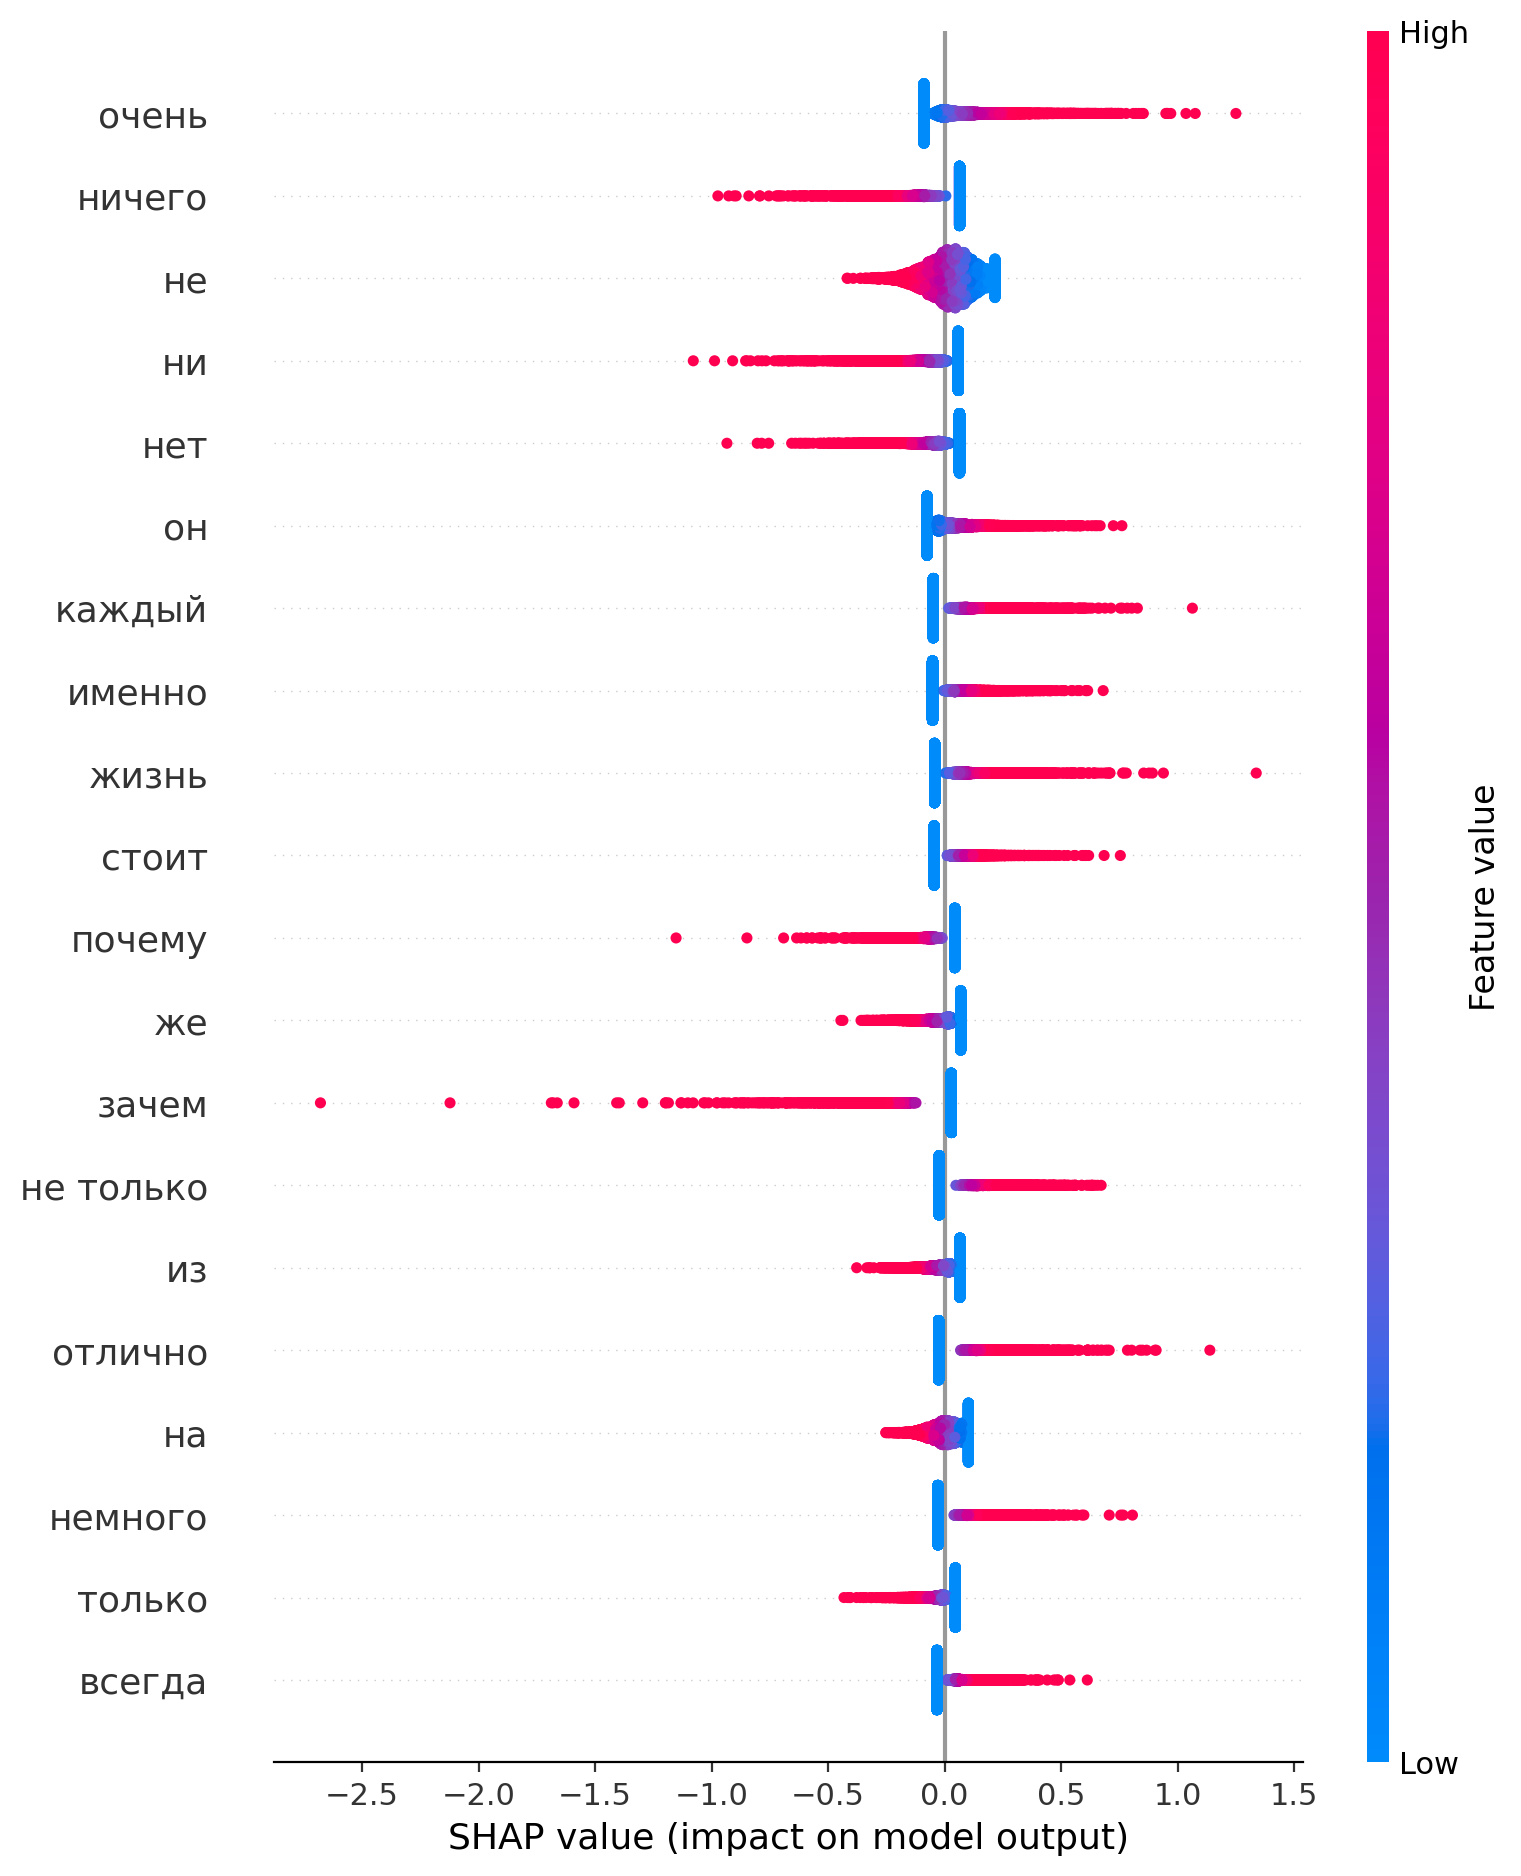

In [63]:
shap.summary_plot(
    shap_values,
    test_vectors_array,
    feature_names=review_vectorizer.get_feature_names_out(),
    class_names=log_reg.classes_,
)

#### Explain review's sentiment prediction

In [77]:
from IPython.display import display

In [79]:
ind = 2

display(shap.force_plot(
    explainer.expected_value,
    shap_values[ind, :],
    test_vectors_array[ind, :],
    feature_names=review_vectorizer.get_feature_names_out(),
))

## To Do

- Follow the article https://developers.google.com/machine-learning/guides/text-classification?hl=en
- Adding stopwords, but filter them using top-N trigrams not to loose important words
- Saving fitted vectorizer separately (this way we can use different models on the same features)
- Explaining predictions